In [2]:
!pip install pymc3
!pip install GPy

     |████████████████████████████████| 1.0MB 10.7MB/s 
     |████████████████████████████████| 71kB 9.8MB/s 
  Created wheel for GPy: filename=GPy-1.9.9-cp36-cp36m-linux_x86_64.whl size=2633926 sha256=b323082bf8f79119b40e4ffb739520135195be41accbe691bb267c6e8b6e20ea
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102551 sha256=ce230eb270eec130c48fd6af9dfeb0e0e88b7c63b9e82cd17ad4af0c6b8efc1a
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPy paramz


In [3]:
import pymc3 as pm
import GPy as GPy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
from scipy.stats import linregress 
%matplotlib inline

In [4]:
from google.colab import files
uploaded = files.upload()


Saving test.csv to test.csv
Saving train.csv to train.csv


In [5]:
df_train = pd.read_csv(io.BytesIO(uploaded['train.csv']))
df_test = pd.read_csv(io.BytesIO(uploaded['test.csv']))

**Data Exploration**

In [10]:
#generate the time intervals
time = np.linspace(0,1,100)

In [11]:
df_train.head()

Id         0         1         2  ...        97        98        99  Category
0  120  0.147298 -0.142030  0.091737  ... -0.008333  0.168574  0.123273         0
1  121  0.115710  0.105061  0.038446  ...  0.020398  0.039687  0.217384         0
2  122 -0.548826 -0.466551 -0.650890  ... -0.019942  0.058902  0.053936         0
3  123  0.192618  0.291155 -0.042980  ...  0.190920  0.251743  0.337730         1
4  124  0.075706  0.069045 -0.019818  ...  0.554588  0.471489  0.384229         1

[5 rows x 102 columns]

In [12]:
y=(df_train[df_train.columns[1:-1]])


In [13]:
print(y.shape)
print(df_train.shape)
print(df_test.shape)
print(time.shape)

(75, 100)
(75, 102)
(120, 101)
(100,)


In [14]:
y.head()

0         1         2  ...        97        98        99
0  0.147298 -0.142030  0.091737  ... -0.008333  0.168574  0.123273
1  0.115710  0.105061  0.038446  ...  0.020398  0.039687  0.217384
2 -0.548826 -0.466551 -0.650890  ... -0.019942  0.058902  0.053936
3  0.192618  0.291155 -0.042980  ...  0.190920  0.251743  0.337730
4  0.075706  0.069045 -0.019818  ...  0.554588  0.471489  0.384229

[5 rows x 100 columns]

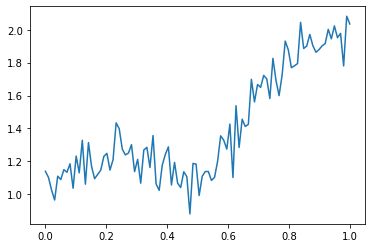

In [15]:
#Look at one example
plt.plot(time,y.iloc[47])

### **`THE GAUSSIAN PROCESSES MODEL`**

Following issues:

Regular errors about "zero values" and NaN values are obtained. 
  
  LinAlgError: 3-th leading minor of the array is not positive definite
  array must not contain infs or NaNs

  Last model was about 50% accurate- need to look at adding a generic term, but need to resolve the LinAlgError issue first


In [38]:
def make_basis(x):
    # the components are 1,x, cos(2 \pi x), sin(2 \pi x)...
    nonlinear=np.hstack([np.tanh(1+2*x),np.tanh(1+4*x),np.tanh(1+6*x),np.tanh(1+8*x),np.tanh(1+10*x)])
    periodic = np.hstack([np.cos(2*np.pi*x),np.sin(2*np.pi*x),np.cos(4*np.pi*x),np.sin(4*np.pi*x),np.cos(6*np.pi*x),np.sin(6*np.pi*x),np.cos(8*np.pi*x),np.sin(8*np.pi*x),np.cos(10*np.pi*x),np.sin(10*np.pi*x),np.cos(12*np.pi*x),np.sin(12*np.pi*x)])
    
    return np.hstack([np.ones((x.shape[0],1)),x,nonlinear, periodic ]) 

#  periodic basis starts at column:
col_per = 7

In [39]:
#baseline model
def run_model1(x,y,plot=False):    
    H = make_basis(x.reshape(-1,1))
    #normalize the data
    yn = (y-np.mean(y))/np.std(y)
    
    #select non periodic components of the basis
    H_np = H[:,0:col_per]

    with pm.Model() as model:
        #prior
        w = pm.Normal('weights', mu=0, sd=50, shape=(H.shape[1],))
        sigma = pm.HalfCauchy('sigma', 5)

        #linear model
        mu = pm.Deterministic('mu', pm.math.matrix_dot(H,w).T)

        #likelihood
        y_obs = pm.Normal('y', mu=mu, sd=sigma, observed=yn)

        #we can do  an approximated inference
    with model:
        inference = pm.ADVI()
        approx = pm.fit(60000, method=inference)
        
    posterior = approx.sample(draws=500)
    
    all_prediction = np.dot(H,posterior['weights'].T).T
    non_periodic_prediction = np.dot(H_np,posterior['weights'][:,0:col_per].T).T
    if plot==True:
        plt.figure()
        plt.plot(x,np.mean(all_prediction,axis=0),'r', label='Overall Mean')
        plt.plot(x,np.mean(non_periodic_prediction,axis=0),'b', label='Mean of the non-periodic comp.')
        plt.legend()
        plt.scatter(x,yn)
    Gradients = []
    for i in range(non_periodic_prediction.shape[0]):
        Gradients.append(np.min(np.gradient(non_periodic_prediction[i,:], x)))
        
    posterior_probability_deriviative_is_positive = len(np.where(np.array(Gradients)>0)[0])/len(Gradients)
    print("probability that the function is increasing=", posterior_probability_deriviative_is_positive)
    if posterior_probability_deriviative_is_positive>0.95:
        print("1 predict")
        return 1
    else:
        print("0predict")
        return 0




#Try some samples from training set

In [40]:
start=20
finish=22

for i in range (start,finish):
  index=i
  y = df_train.iloc[index,1:-1].values
  X=time[:, None]
  run_model1(X, y)

Average Loss = 163.32: 100%|██████████| 60000/60000 [00:28<00:00, 2124.57it/s]
Finished [100%]: Average Loss = 163.32


ValueError: ignored


Decision = pd.DataFrame(columns=['Id','Category'])

#for r in range(df_train.shape[0]):
for r in range(df_train.shape[0]): #might need to fix this line
    id_row = df_train.iloc[r,0]
    print(r)
    y = df_train.iloc[r,1:-1].values
    #print(y.shape)
    #print(time.shape)
    X=time[:, None]

    decision = run_model(X,y)
    Decision = Decision.append({'Id': int(id_row), 'Category': int(decision)}, ignore_index=True) 
    #print(Decision)
    Decision.to_csv("decision.csv",  index=False)





In [ ]:
y_actual=df_train.iloc[:,-1]
y_predicted=Decision['Category']
print(y_actual.shape)
print(y_predicted.shape)


#Training Set Accuracy

correct=np.sum(y_actual==y_predicted)
accuracy=correct/len(y_actual)
print(accuracy)

(75,)
(75,)
0.52


In [ ]:
ya = df_train.iloc[8,1:-1].values
ya.dtype

dtype('float64')

In [ ]:
def make_classification(df,x,train_test,low_index,high_index):
  #note a=-1 for training set and 0 for test set

  Decision = pd.DataFrame(columns=['Id','Category'])
  for r in range(low_index,high_index): #might need to fix this line
      id_row = df.iloc[r,0]
      print(r)

      if train_or_test==-1:
        y = df.iloc[r,1:-1].values
      else:
        y = df.iloc[r,1:].values
    
      print(y.shape)
      print(time.shape)
      X=x[:, None]

      decision = run_model(X,y)
      Decision = Decision.append({'Id': int(id_row), 'Category': int(decision)}, ignore_index=True) 
      #print(Decision)

     
  return Decision



In [ ]:
Decision1=make_classification(df_test,time,0,10)

In [ ]:
Decision2=make_classification(df_test,time,10,20)

In [ ]:
Decision.to_csv("decision.csv",  index=False)
files.download('decision.csv')

In [ ]:
def accuracy_estimate(dfactual,dfpredicted):
     y_actual=dfactual.iloc[:,-1]
     y_predicted=dfpredicted['Category']
     #print(y_actual.shape)
     #print(y_predicted.shape)

      #Accuracy
      correct=np.sum(y_actual==y_predicted)
      accuracy=correct/len(y_actual)
      print("The accuracy is",accuracy)
return

## Ideas to improve baseline

1. Adding another non-linear basis function components (e.g., $tanh(w0+w1x)$) and seeing if you can better split the seasonal and non-seasonal component.
2. In the second example, the sin/cos basis function fits the nonlinear function, but it is clear that the obtained mean function is non-periodic. By definition a function is periodic in the interval [0,1] if you see at least one full cycle (e.g. $cos(\pi x)$ is not peridic in [0,1] but $cos(2 \pi x)$ is). So you could try to verify if the function is periodic or not. In case it is periodic you can use "non_periodic_prediction" for checking if the function is increasing or not. Instead, if the function is not periodic that you could use  "all_prediction" for checking if the function is increasing or not. How can you test if a function is periodic or not given your basis functions in H ?
3. The baseline model computes the derivative of the non-seasonal component and checks if the derivative is non-negative for all $x\in[0,1]$ as a way to assess if sales are increasing. Could an analytical derivative work better in the above case?
4. You could try to use GPs
5. Is the decision criterion "posterior_probability_deriviative_is_positive>0.95" the best way to make decisions? Maybe you would do better if you take into account the way weighted accuracy is defined for this competition.